# <font color='red'>Step 1: Upload Data and Preprocess</font>

In [1]:
library(data.table)
library(plyr)
library(dplyr)
library(tm)
library(tidytext)
library(stringr)
library(magrittr)
library(topicmodels)
library(igraph)
library(quanteda)
library(extrafont)
library(ggraph)
library(ggpubr)
font_import(prompt = FALSE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: NLP


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Package version: 4.1.0
Unicode version: 15.1
ICU version: 75.1

Parallel computing: disabled

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘package:tm’:

    stopwords


The following objects are 

In [126]:
df <- fread("/Users/heatherharper/Desktop/NMSU/RESEARCH_Ongoing/UK_Speech/US_UK_NEW_Analysis2025/US_ImmigrationSpeeches.csv")

In [127]:
setwd("/Users/heatherharper/Desktop/NMSU/RESEARCH_Ongoing/UK_Speech/US_UK_NEW_Analysis2025/US_Venture1993")

In [128]:
df <- df %>%
  mutate(date.yr.m = substr(date, 1, 6),
         month = substr(date, 5, 6))

# Make sure date variable is formatted as a date
df$date <- as.Date(as.character(df$date), format = "%Y%m%d")

#extra stop list; need to get rid of a couple that we don't need--was trying to figure out correct word form
new_stop <- c('also', 'hon', 'minister', 'debate', 'secretaries', 'secretar', 'governs', 'speaker', 'madam', 'congress',
              'secretary', 'bill', 'friend', 'committee', 'committees', 'will', 'government', 'governing', 'president', 
              'must', 'party', 'get', 'go', 'want', 'say', 'one', 'govern', 'people', 'peoples', 
              'come', 'can', 'us', 'know', 'mr', 'said', 'refer', 'however', 'make', '£', 'member', 'house', 'gentleman', 'gentlemen',
              'think', 'take', 'see', 'look', 'even', 'thing', 'let', 'go' )

#fix encoding 
df$text <- iconv(df$text, from = "UTF-8", to = "UTF-8", sub = "")

In [129]:
#preprocess and stem
df$text <-
  df$text %>%
  tolower() %>%
  gsub("'s", '',.)%>%
  gsub('[0-9]+', '',.)%>%
  gsub("\\£", " ",.) %>%
  #gsub("\\£", " ",.)%>%
  str_replace_all(., pattern = "[:punct:]|(\\—)|([\\p{Pd}\\xAD\\u2212]+)", replacement = " ") %>%
  gsub('\\b\\w{1,2}\\b',' ',.) %>% #to get rid of words less than 3 letters long
  gsub("—", " ",.) %>%
  removeWords(., c(new_stop)) %>%
  removeWords(., stopwords("en")) %>%
  stemDocument(., language="english")

In [130]:
# Drop columns and create display_as variable
df <- df %>%
  select(-chamber.y, -state.y, -gender.y, -file, -char_count) %>%
  mutate(display_as = paste(firstname, lastname))

In [131]:
#Recode parties to just 3 
df <- df %>% mutate(party=recode(party, 'C'='Other', 'I'='Other','N'='Other', 
                                 'D'='Democrat','R'='Republican'))

In [132]:
table(df$party)


  Democrat      Other Republican 
     27158        127      20101 

In [133]:
dim(df)

[1] 47386    30

# <font color='orange'>Step 2: Select Event Period</font>

In [134]:
# U.S. Venture Grounding 1993
before_90 = "1993-03-08" 
before_1 = "1993-06-05"
event = "1993-06-06"
after_90 = "1993-09-04"
event_name = "U.S. Venture Grounding 1993 Event"
event_name_pre = "Pre1993US"
event_name_post = "Post1993US"
event_short = "1993USEvent"

df_event <- subset(df, date>= before_90 & date <= after_90)

In [135]:
colnames(df_event)

[1] "speech_id"          "text"               "speakerid"         
 [4] "lastname"           "firstname"          "chamber.x"         
 [7] "state.x"            "gender.x"           "party"             
[10] "district"           "nonvoting"          "date"              
[13] "number_within_file" "speaker"            "first_name"        
[16] "last_name"          "line_start"         "line_end"          
[19] "word_count"         "nchar"              "doc_id"            
[22] "migration"          "migration_rate"     "migration_always"  
[25] "migration_border"   "border_dec"         "border99"          
[28] "date.yr.m"          "month"              "display_as"

In [136]:
dim(df_event)

[1] 525  30

# <font color='green'>Step 3a: Run STM and get four different word weights </font>

In [137]:
library(stm)
library(ggplot2)
library(reshape2)
library(tidytext)
library(textstem)
library(textreg)
library(LDAvis)
#library(servr)

In [138]:
#create covariate matrix
meta <- df_event %>% 
  select(date, party)

In [139]:
processed <- textProcessor(df_event$text)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


In [140]:
out <- prepDocuments(processed$documents, processed$vocab)

Removing 4316 of 9080 terms (4316 of 78397 tokens) due to frequency 
Your corpus now has 525 documents, 4764 terms and 74081 tokens.

In [141]:
#with covariates; not working currently 
Bill_STM <- stm(documents = out$documents, vocab = out$vocab,
              K = 20, prevalence =~ party,
              max.em.its = 75, data = df_event,
              init.type = "Spectral", verbose = FALSE)

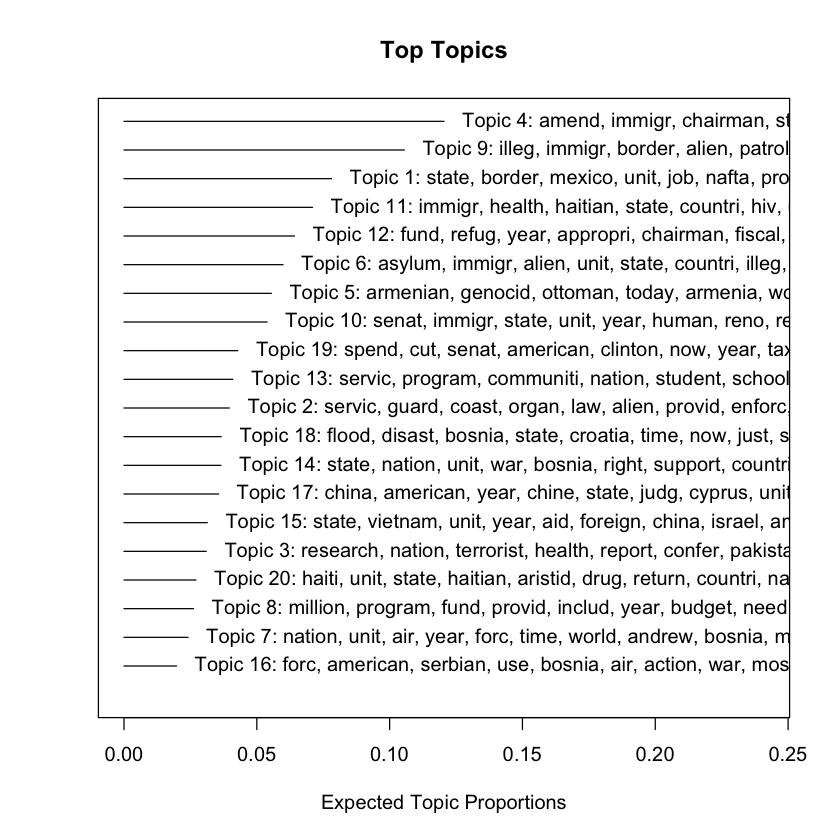

In [142]:
plot(Bill_STM, n=10)

In [143]:
labelTopics(Bill_STM) 

Topic 1 Top Words:
 	 Highest Prob: state, border, mexico, unit, job, nafta, problem 
 	 FREX: mexico, nafta, mexican, compani, wast, colonia, environ 
 	 Lift: cholera, clemen, maquiladora, nogal, paz, raw, rio 
 	 Score: nafta, mexico, colonia, mexican, wastewat, nogal, compon 
Topic 2 Top Words:
 	 Highest Prob: servic, guard, coast, organ, law, alien, provid 
 	 FREX: coast, guard, custom, farmwork, migrant, asian, vessel 
 	 Lift: farmwork, navig, oilspil, cutter, disgust, exempt, maritim 
 	 Score: coast, exempt, smuggl, alien, guard, farmwork, museum 
Topic 3 Top Words:
 	 Highest Prob: research, nation, terrorist, health, report, confer, pakistan 
 	 FREX: research, sourc, nih, pakistan, terrorist, cancer, institut 
 	 Lift: discoveri, fetal, milit, osteoporosi, parkinson, sourc, tissu 
 	 Score: sourc, research, nih, pakistan, terrorist, hiv, disea 
Topic 4 Top Words:
 	 Highest Prob: amend, immigr, chairman, state, illeg, servic, vote 
 	 FREX: amend, citizenship, registr, ch

In [144]:
# Run labelTopics
labels <- labelTopics(Bill_STM, topics = 1:20, n = 10)

# Number of topics
num_topics <- ncol(labels$prob)

# Function to collapse words into a comma-separated string for each topic
collapse_words <- function(mat) {
  apply(mat, 2, function(words) paste(words, collapse = ", "))
}

# Apply to each label type
prob_list  <- collapse_words(labels$prob)
frex_list  <- collapse_words(labels$frex)
lift_list  <- collapse_words(labels$lift)
score_list <- collapse_words(labels$score)

# Combine into a data frame
topic_labels_df <- data.frame(
  Topic = 1:20,
  Prob = prob_list,
  Frex = frex_list,
  Lift = lift_list,
  Score = score_list,
  stringsAsFactors = FALSE
)

# View the result
head(topic_labels_df)

# Export to CSV
write.csv(topic_labels_df, "STM_topic_labels_wide.csv", row.names = FALSE)

Topic
1 1    
2 2    
3 3    
4 4    
5 5    
6 6    
  Prob                                                                                                                                                         
1 state, servic, research, amend, armenian, asylum, nation, million, illeg, senat, immigr, fund, servic, state, state, forc, china, flood, spend, haiti        
2 border, guard, nation, immigr, genocid, immigr, unit, program, immigr, immigr, health, refug, program, nation, vietnam, american, american, disast, cut, unit
3 mexico, coast, terrorist, chairman, ottoman, alien, air, fund, border, state, haitian, year, communiti, unit, unit, serbian, year, bosnia, senat, state      
4 unit, organ, health, state, today, unit, year, provid, alien, unit, state, appropri, nation, war, year, use, chine, state, american, haitian                 
5 job, law, report, illeg, armenia, state, forc, includ, patrol, year, countri, chairman, student, bosnia, aid, bosnia, state, croatia, clinton, aristid       
6 nafta, alien, confer, servic, world, countri, time, year, countri, human, hiv, fiscal, school, right, foreign, air, judg, time, now, drug                    
  Frex                                                                                                                                                                                
1 mexico, coast, research, amend, armenian, asylum, andrew, radio, patrol, reno, hiv, fiscal, youth, baltic, vietnam, fisheri, cyprus, disast, spend, haiti                           
2 nafta, guard, sourc, citizenship, armenia, fraudul, air, marti, illeg, janet, infect, resettl, volunt, flag, israel, landmin, asianpacif, flood, recoveri, aristid                  
3 mexican, custom, nih, registr, ottoman, claim, serbia, facil, border, attorney, haitian, fund, minnesota, milosev, communist, serbian, cypriot, croatia, tax, cocain                
4 compani, farmwork, pakistan, chairman, empir, document, clean, global, agent, justic, hivinfect, appropri, student, somalia, loan, weapon, inva, kurd, deficit, haitian             
5 wast, migrant, terrorist, vote, genocid, airport, bombard, technolog, california, ireland, guantanamo, request, school, sovereignti, cuban, intellig, island, kurdish, economi, drug
6 colonia, asian, cancer, california, commemor, smuggl, ladi, budget, alien, simon, disea, resciss, educ, kosovo, bank, balkan, chine, croatian, unemploy, coup                       
  Lift                                                                                                                                                                                      
1 cholera, farmwork, discoveri, nongerman, anatolian, inadmiss, montenegro, earmark, apprehen, congreg, contagi, auster, advisori, anthem, ford, ammunit, asianpacif, deem, acrobat, arlstid
2 clemen, navig, fetal, resent, azerbaijan, loophol, ogata, noaa, beam, dade, gerinan, carryov, anwatin, banner, indochina, managua, athlet, demjanjuk, sake, hungarian                     
3 maquiladora, oilspil, milit, ballot, blot, mir, thai, omb, bogeyman, patrick, leprosi, committeereport, bestrun, barbara, lobbi, migratori, barb, leve, belt, blackmun                    
4 nogal, cutter, osteoporosi, motorvot, caucasus, aground, widow, sba, bogeymen, simon, sterl, homemak, bureaucrat, csce, reciproc, planner, berlin, acr, consumpt, brandnew                
5 paz, disgust, parkinson, registr, conscript, aimal, bed, juror, byproduct, junta, syphili, reconven, campus, estonian, stateown, tube, biliraki, cow, dust, caputo                        
6 raw, exempt, sourc, clarif, discredit, ajaj, detroit, nist, donald, lous, afflict, acda, civic, jona, technician, woolsey, briberi, crest, gridlock, cedra                                
  Score                                                                                                                                                                    
1 nafta, coast, sourc, amend, armenian, asylum, se

# <font color='green'>Step 4: Extract Gamma DF, Transform to Binary, divide into Pre and Post Period</font>

In [145]:
#create gamma matrix
dfg <- as.data.frame(Bill_STM$theta)

dfg[] <- t(apply(dfg, 1, function(x) replace(x, x == max(x, na.rm = TRUE), 1)))

In [146]:
#try to get gamma matrix for speeches
dfg_all <- rbind.fill( df_event, dfg)

#then convert rest of values using threshold
x <- 0.2
dfg[dfg>=x]=1
dfg[dfg<x]=0

In [147]:
dfg$author <- df_event$display_as
dfg$date <- df_event$date

#put author and date columns at the front
dfg <- dfg[, c(21:22, 1:20)]

In [148]:
#Event dfs
dfg_pre <- subset(dfg, date>= before_90 & date <= before_1) %>%
    select(-date)

dfg_post <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)

#Speeches in each
nrow(dfg_pre)
nrow(dfg_post)

[1] 188

[1] 337

In [149]:
dfg_pre = aggregate(dfg_pre,
                    by = list(dfg_pre$author),
                    FUN = max)

dfg_post = aggregate(dfg_post,
                     by = list(dfg_post$author),
                     FUN = max)

In [150]:
dim(dfg_pre)
dim(dfg_post)

[1] 114  22

[1] 159  22

# <font color='blue'> Step 5: PRE & POST Event Networks</font>

## <font color='DodgerBlue'> 5.1 Drop author names</font>

### PRE

In [151]:
### pre period- drop author names before running and rename topic names from V1 -> 1
rownames(dfg_pre) <- dfg_pre$Group.1

dfg_pre <- dfg_pre %>%
  select(-Group.1, -author)

colnames(dfg_pre) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

### POST

In [152]:
### pre period- drop author names before running and rename topic names from V1 -> 1
rownames(dfg_post) <- dfg_post$Group.1

dfg_post <- dfg_post %>%
  select(-Group.1, -author)

colnames(dfg_post) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

## <font color='DeepSkyBlue'> 5.2 Speaker-Concept Network</font>

### PRE

In [233]:
bn_full_pre <- graph_from_biadjacency_matrix(dfg_pre)


l7 <- layout_with_fr(bn_full_pre)
l7 <- norm_coords(l7, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes2 <- c(rep(5, 114), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

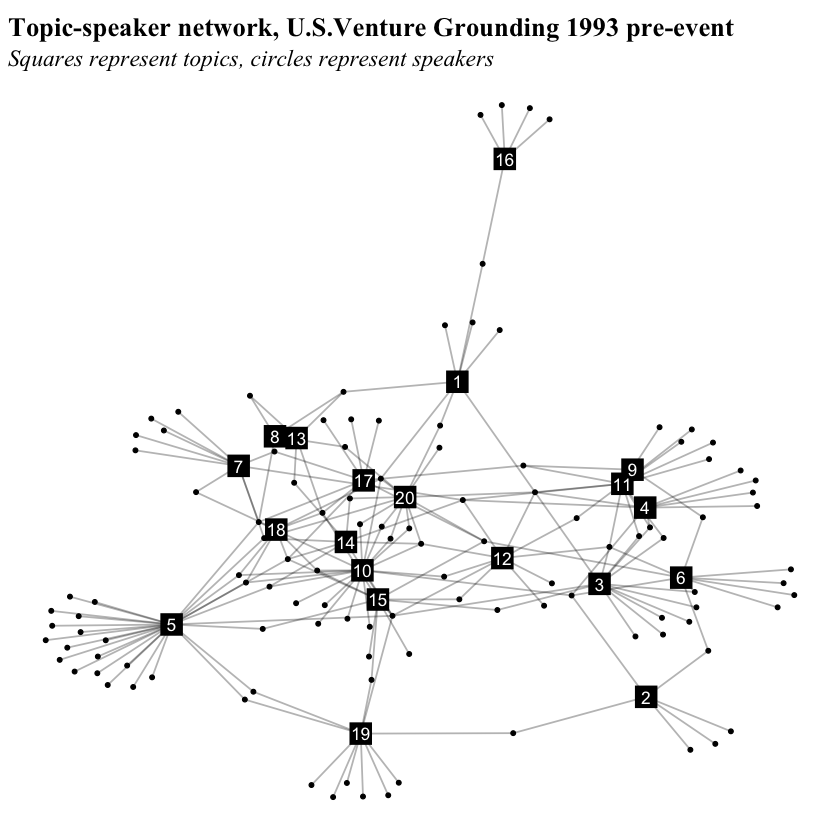

In [241]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre <- ggraph(bn_full_pre, layout = 'fr') +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Topic-speaker network, U.S.Venture Grounding 1993 pre-event",
    subtitle = "Squares represent topics, circles represent speakers"
  ) 

g_dov_pre

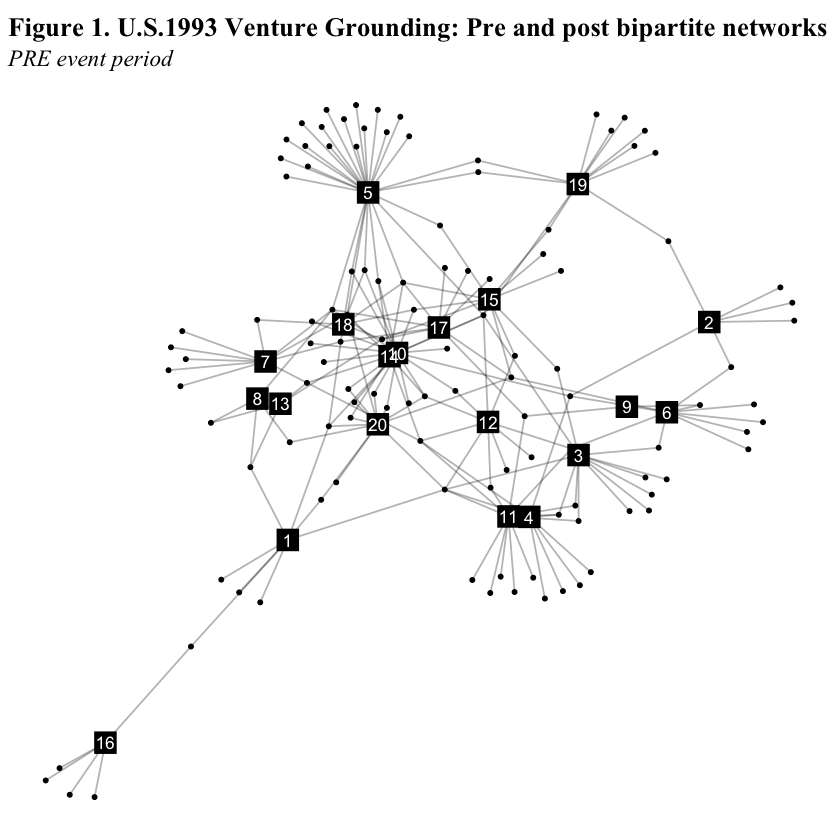

In [246]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre2 <- ggraph(bn_full_pre, layout = l7) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Figure 1. U.S.1993 Venture Grounding: Pre and post bipartite networks",
    subtitle = "PRE event period"
  ) 

g_dov_pre2

### POST 

In [247]:
bn_full_post <- graph_from_biadjacency_matrix(dfg_post)


l8 <- layout_with_fr(bn_full_post)
l8 <- norm_coords(l8, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes3 <- c(rep(5, 159), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

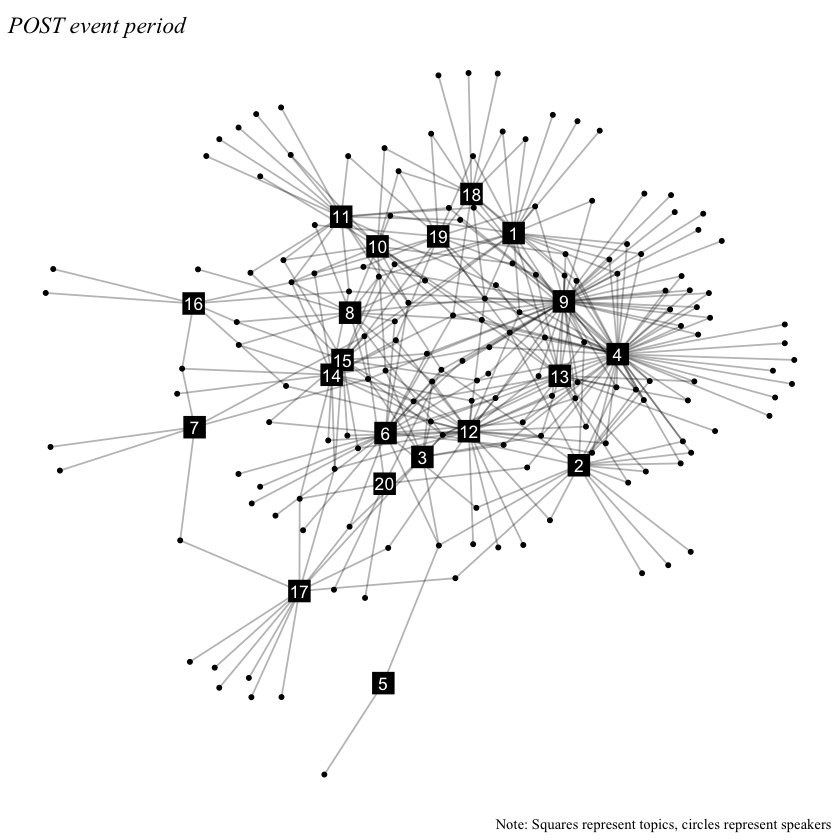

In [248]:
g_dov_post <- ggraph(bn_full_post, layout = l8) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_post)$type+1], size= sizes3)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    subtitle = "POST event period",
    caption = "Note: Squares represent topics, circles represent speakers"
  ) 

g_dov_post

In [249]:
combined_plot <- ggarrange(g_dov_pre2, g_dov_post,nrow=2, heights = c(2, 2), align="v")

In [250]:
ggsave("US_Venture1993combined_plot.jpeg", combined_plot, height = 10, width = 8)

## <font color='MediumPurple'> 6.3 Speaker-Speaker Network</font>

### PRE

In [160]:
### divide into actor-actor and concept-concept networks pre-period may-jul 15

# turn into bipartite network 
bn.pr_f_pre <- bipartite_projection(bn_full_pre)

# actor-actor
bn.mem_f_pre <- bn.pr_f_pre$proj1 
bn.mem_f_pre

# looking at edge weights  (1 = actors connected through 1 topic; 2 = connected through 2 topics...)
E(bn.mem_f_pre)$weight

# topic-topic 
bn.topics_f_pre <- bn.pr_f_pre$proj2
bn.topics_f_pre

l2 <- layout_with_fr(bn.mem_f_pre)
l2 <- norm_coords(l2, ymin=-0.8, ymax=0.7, xmin=-0.9, xmax=1)

IGRAPH c38d575 UNW- 114 1085 -- 
+ attr: name (v/c), weight (e/n)
+ edges from c38d575 (vertex names):
 [1] ALAN SIMPSON--BARBARA MIKULSKI   ALAN SIMPSON--JEFF BINGAMAN     
 [3] ALAN SIMPSON--LAMAR SMITH        ALAN SIMPSON--ROBERT DOLE       
 [5] ALAN SIMPSON--THOMAS LEWIS       ALAN SIMPSON--EDWARD ROYCE      
 [7] ALAN SIMPSON--GERALD SOLOMON     ALAN SIMPSON--HENRY WAXMAN      
 [9] ALAN SIMPSON--ITIMOUS VALENTINE  ALAN SIMPSON--RANDALL CUNNINGHAM
[11] ALAN SIMPSON--ROMANO MAZZOLI     ALAN SIMPSON--TILLIE FOWLER     
[13] ALAN SIMPSON--ALFONSE DAMATO     ALAN SIMPSON--BILL MCCOLLUM     
[15] ALAN SIMPSON--CHARLES GRASSLEY   ALAN SIMPSON--DOUGLAS BEREUTER  
+ ... omitted several edges

[1] 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [75] 2 2 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 [112] 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 2 3
 [149] 1 1 2 2 2 1 1 1 2 1 1 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 1 2 2 1 3 2 1 1 1 1 1
 [186] 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 2 1 1 1 1
 [223] 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [260] 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [297] 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [334] 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 3 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1
 [371] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [408] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 2
 [445] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [482] 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 [519] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 [556] 1 1 1 2 2 1 1 1 3 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 1 1 2 1 1 1 1
 [593] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [630] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [667] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [704] 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 2 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 [741] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 2 1 1 1 1 1 1 1
 [778] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [815] 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 [852] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [889] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [926] 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [963] 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1000] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1037] 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
[1074] 1 1 1 1 1 1 1 1 1 1 1 1

IGRAPH d5f961b UNW- 20 93 -- 
+ attr: name (v/c), weight (e/n)
+ edges from d5f961b (vertex names):
 [1] 1 --10 1 --18 1 --20 1 --8  1 --13 1 --3  1 --4  1 --11 1 --12 1 --16
[11] 2 --4  2 --6  2 --10 2 --19 3 --15 3 --6  3 --11 3 --12 3 --5  3 --10
[21] 3 --14 3 --19 3 --4  3 --20 4 --6  4 --10 4 --7  4 --11 4 --12 4 --14
[31] 4 --20 5 --10 5 --18 5 --7  5 --14 5 --20 5 --8  5 --17 5 --12 5 --15
[41] 5 --19 6 --10 6 --15 6 --17 6 --20 6 --11 6 --12 6 --9  7 --14 7 --18
[51] 7 --20 7 --8  7 --10 7 --17 7 --11 7 --12 8 --10 8 --17 8 --13 8 --20
[61] 9 --11 9 --17 10--18 10--12 10--14 10--20 10--17 10--15 10--19 11--12
[71] 11--14 11--17 11--20 12--14 12--20 12--15 12--19 13--14 13--15 13--17
+ ... omitted several edges

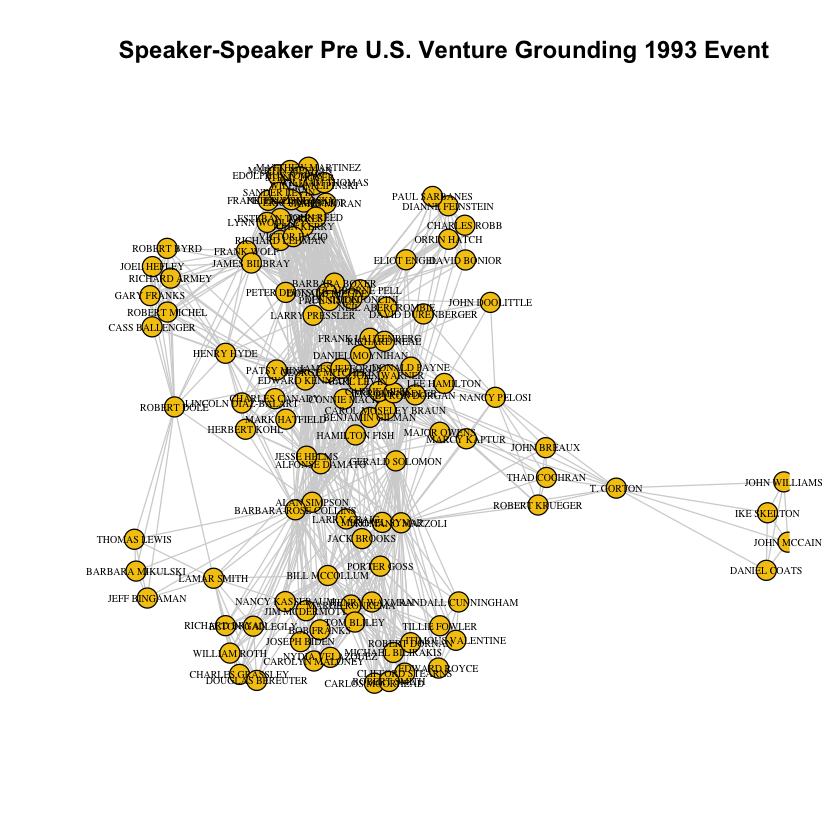

In [161]:
label2 = paste("Speaker-Speaker Pre", event_name, sep=" ")
set.seed(1)
plot(bn.mem_f_pre,vertex.color="#F5C710", main = label2,
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",edge.color = "light grey",
     vertex.size=7, vertex.label.cex=.5, layout= l2*1.2, rescale = FALSE)

### POST

In [162]:
### divide into actor-actor and concept-concept networks post-period 

# turn into bipartite network 
bn.pr_f_post <- bipartite_projection(bn_full_post)
bn.pr_f_post 

bn.mem_f_post <- bn.pr_f_post$proj1 
bn.mem_f_post

bn.topics_f_post <- bn.pr_f_post$proj2
bn.topics_f_post

$proj1
IGRAPH fc6d162 UNW- 159 3818 -- 
+ attr: name (v/c), weight (e/n)
+ edges from fc6d162 (vertex names):
 [1] ALAN SIMPSON--ALFONSE DAMATO   ALAN SIMPSON--DENNIS DECONCINI
 [3] ALAN SIMPSON--DIANNE FEINSTEIN ALAN SIMPSON--DOUGLAS BEREUTER
 [5] ALAN SIMPSON--HAMILTON FISH    ALAN SIMPSON--HARRY REID      
 [7] ALAN SIMPSON--JAMES TRAFICANT  ALAN SIMPSON--JOHN BREAUX     
 [9] ALAN SIMPSON--JOHN JOHNSTON    ALAN SIMPSON--NYDIA VELAZQUEZ 
[11] ALAN SIMPSON--PAUL SIMON       ALAN SIMPSON--PETER DEUTSCH   
[13] ALAN SIMPSON--PETER KING       ALAN SIMPSON--PORTER GOSS     
[15] ALAN SIMPSON--RICHARD BRYAN    ALAN SIMPSON--ROBERT BYRD     
+ ... omitted several edges

$proj2
IGRAPH e24d763 UNW- 20 132 -- 
+ attr: name (v/c), weight (e/n)
+ edges from e24d763 (vertex names):
 [1] 1--4  1--9  1--7  1--14 1--15 1--18 1--20 1--8  1--12 1--19 1--6  1--2 
[13] 1--13 2--4  2--10 2--13 2--19 2--9  2--12 2--3  2--8  2--15 2--17 2--5 
[25] 2--6  2--11 2--20 3--6  3--17 3--12 3--13 3--14 3--7  3--8

IGRAPH fc6d162 UNW- 159 3818 -- 
+ attr: name (v/c), weight (e/n)
+ edges from fc6d162 (vertex names):
 [1] ALAN SIMPSON--ALFONSE DAMATO   ALAN SIMPSON--DENNIS DECONCINI
 [3] ALAN SIMPSON--DIANNE FEINSTEIN ALAN SIMPSON--DOUGLAS BEREUTER
 [5] ALAN SIMPSON--HAMILTON FISH    ALAN SIMPSON--HARRY REID      
 [7] ALAN SIMPSON--JAMES TRAFICANT  ALAN SIMPSON--JOHN BREAUX     
 [9] ALAN SIMPSON--JOHN JOHNSTON    ALAN SIMPSON--NYDIA VELAZQUEZ 
[11] ALAN SIMPSON--PAUL SIMON       ALAN SIMPSON--PETER DEUTSCH   
[13] ALAN SIMPSON--PETER KING       ALAN SIMPSON--PORTER GOSS     
[15] ALAN SIMPSON--RICHARD BRYAN    ALAN SIMPSON--ROBERT BYRD     
+ ... omitted several edges

IGRAPH e24d763 UNW- 20 132 -- 
+ attr: name (v/c), weight (e/n)
+ edges from e24d763 (vertex names):
 [1] 1--4  1--9  1--7  1--14 1--15 1--18 1--20 1--8  1--12 1--19 1--6  1--2 
[13] 1--13 2--4  2--10 2--13 2--19 2--9  2--12 2--3  2--8  2--15 2--17 2--5 
[25] 2--6  2--11 2--20 3--6  3--17 3--12 3--13 3--14 3--7  3--8  3--9  3--4 
[37] 3--15 3--5  3--10 4--15 4--9  4--10 4--13 4--19 4--8  4--12 4--18 4--14
[49] 4--20 4--6  4--17 4--11 5--6  6--17 6--8  6--15 6--9  6--12 6--10 6--14
[61] 6--18 6--11 6--20 6--13 7--17 7--14 7--15 7--18 7--20 7--16 7--8  7--9 
[73] 8--10 8--11 8--14 8--9  8--12 8--18 8--19 8--15 8--13 8--16 8--17 9--12
[85] 9--11 9--14 9--16 9--18 9--19 9--13 9--10 9--20 9--15
+ ... omitted several edges

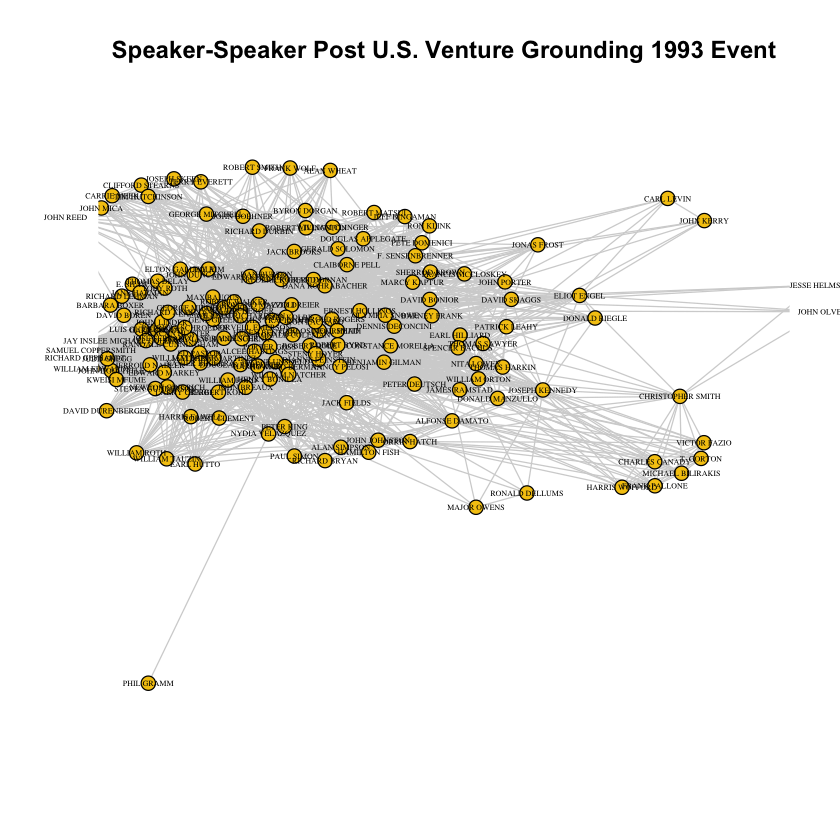

In [163]:
# members - members network post period 
label2= paste("Speaker-Speaker Post", event_name, sep=" ")

l11 <- layout_with_fr(bn.mem_f_post)
l11 <- norm_coords(l11, ymin=-0.8, ymax=0.7, xmin=-1.1, xmax=1.1)

set.seed(1)
plot(bn.mem_f_post,vertex.color="#F5C710", main = label2,
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",edge.color = "light grey",
     vertex.size=5, vertex.label.cex=.4, layout= l11*1.2, rescale = FALSE)

# <font color='Purple'> Step 6: Detect Communities with WalkTrap</font>

## <font color='DarkViolet'> 6A.1: Create Full Walktrap</font>

### PRE

In [164]:
#Create walktrap objects
cluster_pre <- cluster_walktrap(bn.mem_f_pre, steps=2) # 2 random steps 

V(bn.mem_f_pre)$community2 <-  membership(cluster_pre)

g_grouped = bn.mem_f_pre

for(i in unique(V(bn.mem_f_pre)$community2)){
  groupV = which(V(bn.mem_f_pre)$community2 == i)
  g_grouped = add_edges(g_grouped, combn(groupV, 2), attr=list(weight = 2))
}

l4 <- layout_nicely(g_grouped)

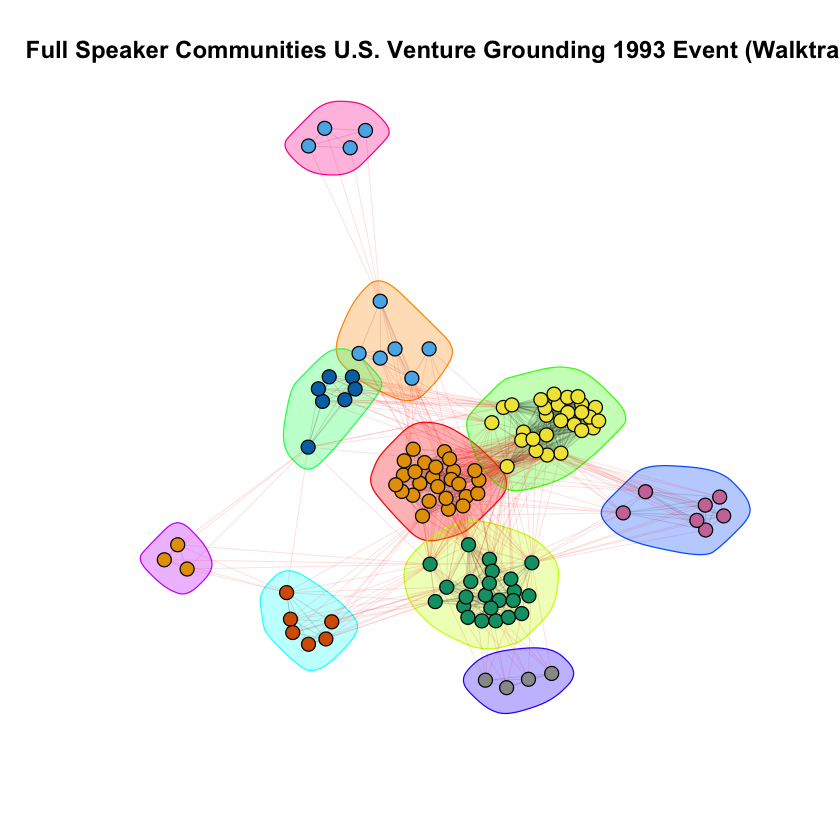

In [230]:
#Original Walktrap 
label4 = paste("Full Speaker Communities", event_name, "(Walktrap)", sep=" ")

set.seed(1)
#pv_pre <- plot(cluster_pre,bn.mem_f_pre,layout = l4*2, vertex.size = 5, edge.width = .1,
     #vertex.label.cex=.3, main = label4)

#don't show names
pv_pre <- plot(cluster_pre,bn.mem_f_pre,layout = l4*2, vertex.size = 5, edge.width = .1,
     vertex.label=NA, main = label4)

In [166]:
ggsave("US_Venture1993_preCommunities_full.jpeg", pv_pre)

Saving 7 x 7 in image


### POST

In [167]:
#Create walktrap objects
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2) # 2 random steps 

V(bn.mem_f_post)$community2 <-  membership(cluster_post)

g_grouped_post = bn.mem_f_post

for(i in unique(V(bn.mem_f_post)$community2)){
  groupV = which(V(bn.mem_f_post)$community2 == i)
  g_grouped_post = add_edges(g_grouped_post, combn(groupV, 2), attr=list(weight = 2))
}

l11 <- layout_nicely(g_grouped_post)

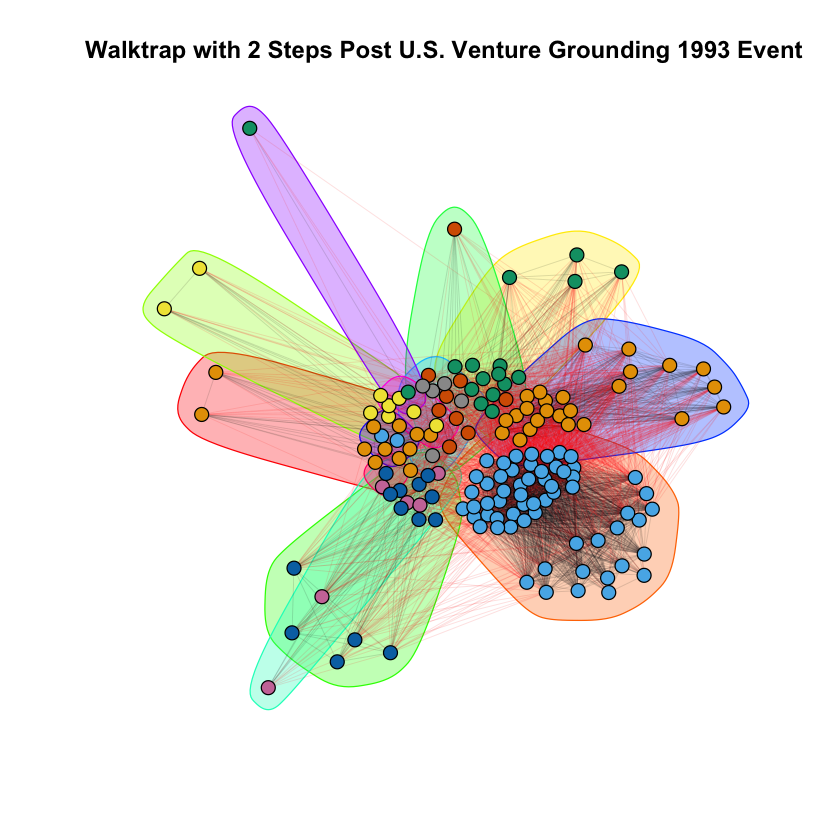

In [231]:
label11 = paste("Walktrap with 2 Steps Post", event_name, sep=" ")

set.seed(1)
#pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     #vertex.label.cex=.3, main = label11)

#Don't show names
pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     vertex.label= NA, main = label11)


In [169]:
ggsave("US_Venture1993_postCommunities_full.png", pv_post, height = 10, width = 8)

## <font color='MediumOrchid'> 6A.2: Color Nodes by Party</font>

### PRE

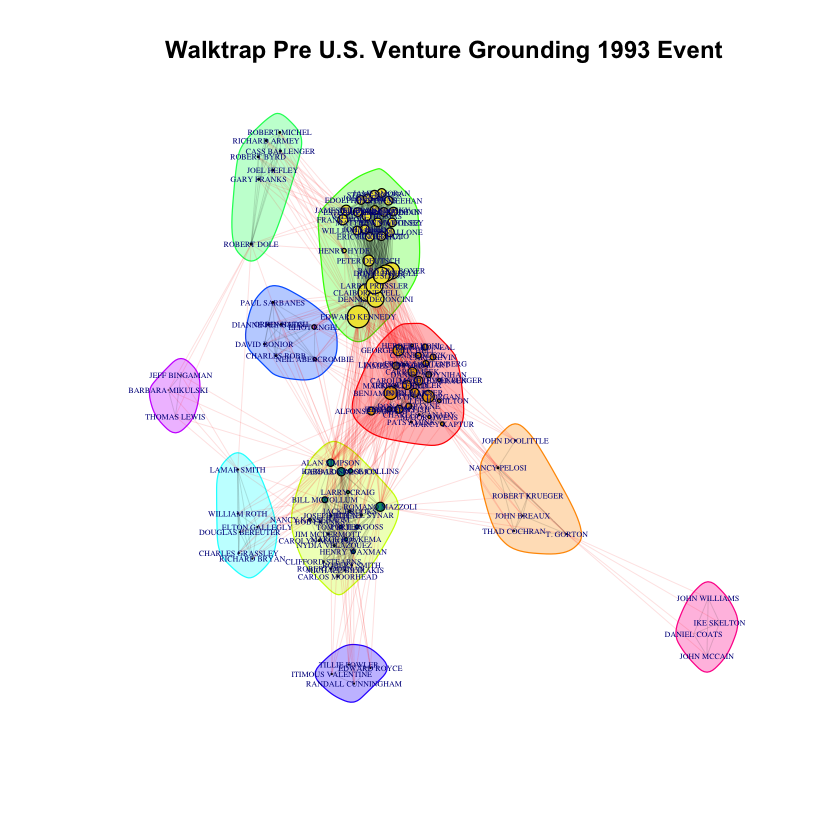

In [170]:
#create separate original dataset based on period
df_pre <- subset(df_event, date>= before_90 & date <= before_1)

d_pre = aggregate(df_pre,
                    by = list(df_pre$display_as),
                    FUN = max)

c_pre = cluster_pre
bn.m_pre = bn.mem_f_pre

eigen_pre <-  eigen_centrality(bn.m_pre) # use actor-actor network
#eigen_pre$vector

V(bn.m_pre)$eigen <- (eigen_pre$vector*8) #size the network nodes by their node degree and attach to network graph

#V(bn.member_f)$eigen

#betweenness
V(bn.m_pre)$between <- betweenness(bn.m_pre, normalized = T)

l5 <- layout_nicely(g_grouped)

label5 = paste("Walktrap Pre", event_name, sep=" ")

#specify vertex.size argument for eigen or betweenness
set.seed(1)
plot(c_pre,bn.m_pre, layout = l5*2, vertex.size = V(bn.m_pre)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label5)

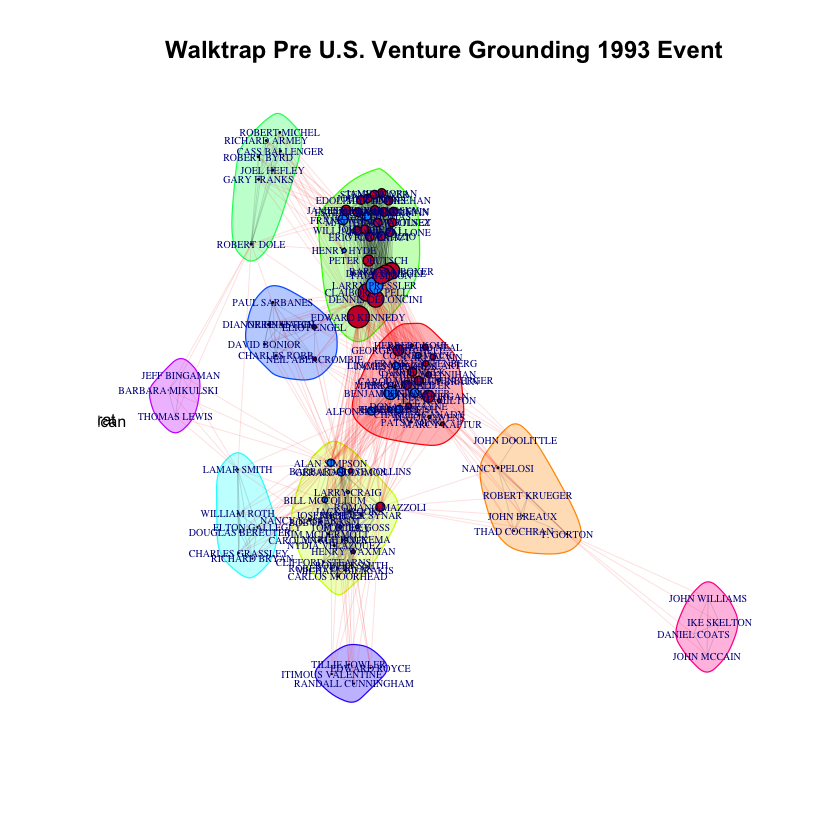

In [171]:
## Party Colors
nodes_party_pre = d_pre %>%
  mutate(group_num = as.numeric(factor(d_pre$party)))

# #CC0033= red, 33FF00 = Green
colors <- c("#CC0033", "#0099FF", "#33FF00")
#note: not all parties will appear in final graph

label6 = paste("Walktrap Pre", event_name, sep=" ")

plot(c_pre, bn.m_pre,
     col=colors[as.numeric(factor(nodes_party_pre$party))],
     vertex.size = V(bn.m_pre)$eigen,
     layout = l5*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex=.5, main = label6)

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_pre$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))

### POST

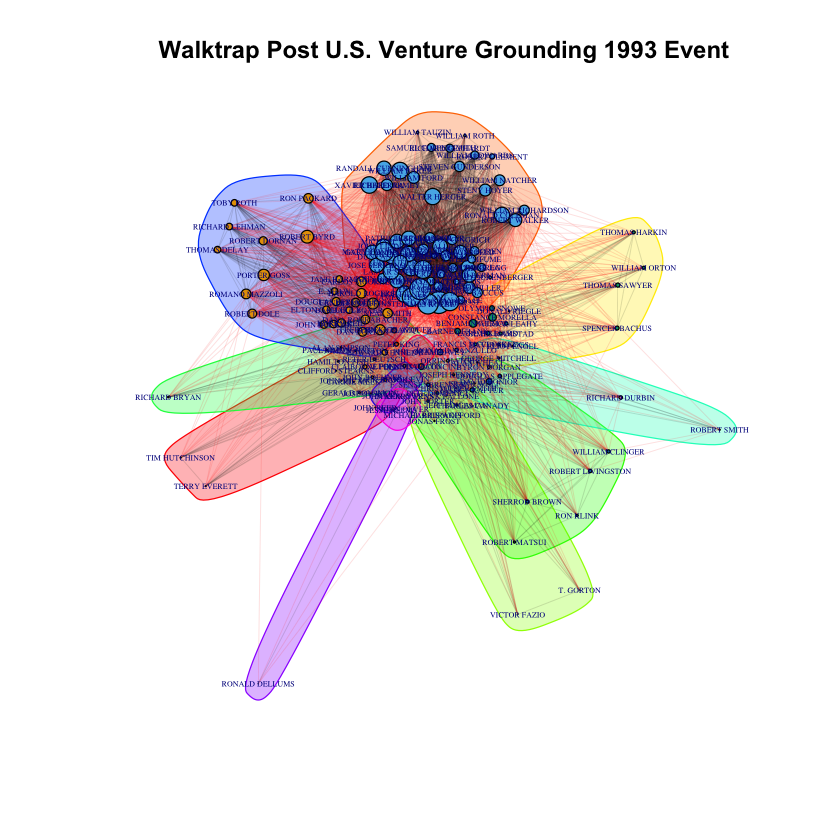

In [172]:
#create separate original dataset based on period
df_post <- subset(df_event, date>= event & date <= after_90)

d_post = aggregate(df_post,
                    by = list(df_post$display_as),
                    FUN = max)

c_post = cluster_post
bn.m_post = bn.mem_f_post

eigen_post <-  eigen_centrality(bn.m_post) # use actor-actor network


V(bn.m_post)$eigen <- (eigen_post$vector*8) #size the network nodes by their node degree and attach to network graph

#V(bn.member_f)$eigen

#betweenness
V(bn.m_post)$between <- betweenness(bn.m_post, normalized = T)

l12 <- layout_nicely(g_grouped_post)

label12 = paste("Walktrap Post", event_name, sep=" ")

#specify vertex.size argument for eigen or betweenness
set.seed(1)
pv_pre_core <- plot(c_post,bn.m_post, layout = l12*2, vertex.size = V(bn.m_post)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label12)


In [173]:
ggsave("US_Venture1993_postCommunities_core.png", pv_pre_core, height = 10, width = 8)

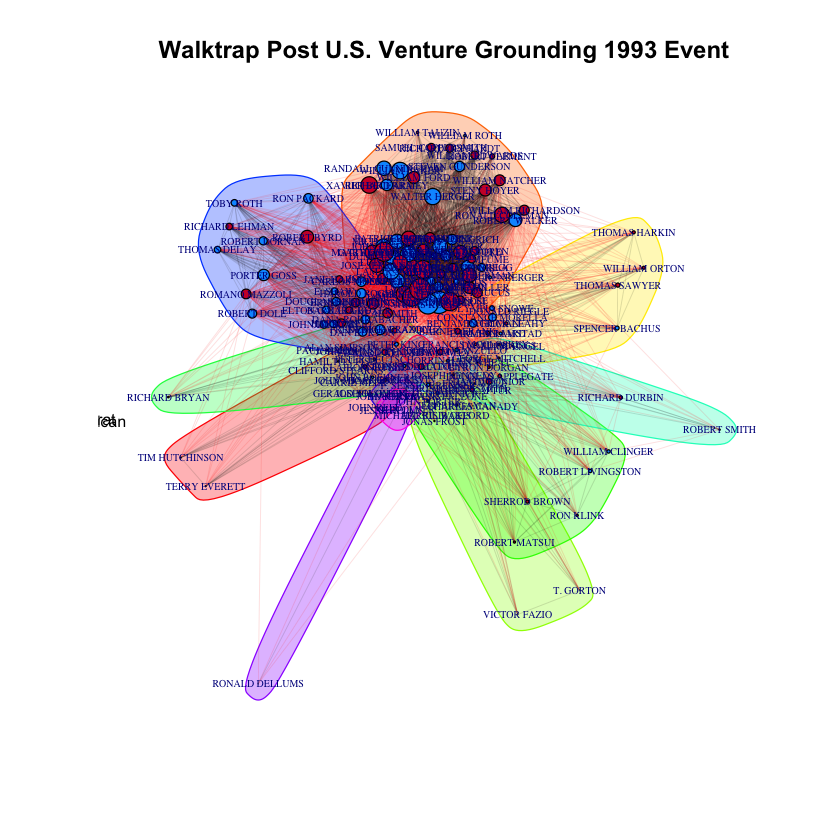

In [174]:
## Party Colors
nodes_party_post = d_post %>%
  mutate(group_num = as.numeric(factor(d_post$party)))

# #CC0033= red, 33FF00 = Green
colors <- c("#CC0033", "#0099FF", "#33FF00")
#note: not all parties will appear in final graph

label13 = paste("Walktrap Post", event_name, sep=" ")

plot(c_post, bn.m_post,
     col=colors[as.numeric(factor(nodes_party_post$party))],
     vertex.size = V(bn.m_post)$eigen,
     layout = l12*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex=.5, main = label13)

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_post$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))


# <font color='Magenta'> STEP 7: Create Subgraph with Core Clusters</font>

### PRE

In [175]:
#subgraph
membership.data.pre <- cbind(cluster_pre$names, cluster_pre$membership) %>%
  data.frame()

#filter out membership less than 5
big_group_pre <- membership.data.pre %>%
  group_by(X2) %>%
  filter(n() >= 5)

group_numbers_pre = membership.data.pre %>%
  group_by(X2) %>%
  filter(n() >= 5) %>%
  pull(X2) %>%
  unique()

In [176]:
big_names_pre <- big_group_pre$X1

nodes_party_sub_pre <- nodes_party_pre[sapply(lapply(nodes_party_pre$display_as, `%in%`, big_names_pre), any),]
nrow(nodes_party_sub_pre)

[1] 103

In [177]:
#adjust to your bn.member_f_pre object
Keep_pre = V(bn.m_pre)[name %in% big_group_pre$X1]

gD2_pre  = induced_subgraph(bn.m_pre, Keep_pre)

In [178]:
c_sub_pre = cluster_pre
c_sub_pre$names <- cluster_pre$names[Keep_pre]
c_sub_pre$membership <- cluster_pre$membership[cluster_pre$membership %in% group_numbers_pre]
c_sub_pre$vcount <- length(c_sub_pre$names)
c_sub_pre$modularity <- modularity(gD2_pre, c_sub_pre$membership, E(gD2_pre)$weight)

In [179]:
length(cluster_pre$names)
length(cluster_pre$membership)
length(cluster_pre$modularity)

length(c_sub_pre$names)
length(c_sub_pre$membership)
length(c_sub_pre$modularity)

[1] 114

[1] 114

[1] 114

[1] 103

[1] 103

[1] 1

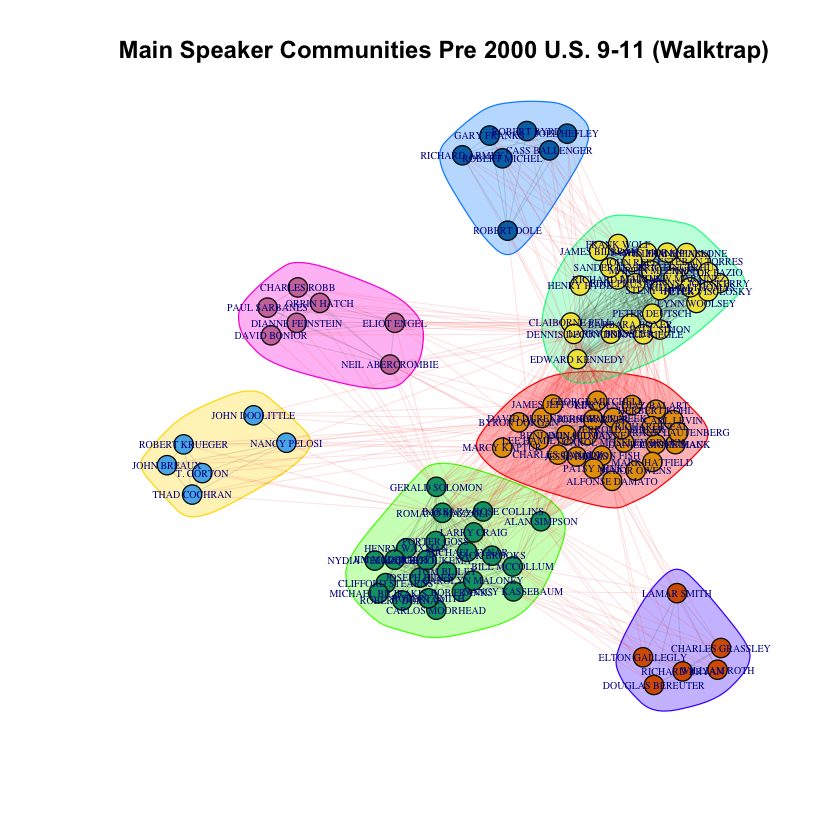

In [180]:
g_grouped_pre2 = gD2_pre

for(i in unique(V(gD2_pre)$community2)){
  groupV = which(V(gD2_pre)$community2 == i)
  g_grouped_pre2 = add_edges(g_grouped_pre2, combn(groupV, 2), attr=list(weight = 2))
}

l.group <- layout_with_fr(g_grouped_pre2)
l.group <- suppressWarnings(norm_coords(l.group, ymin=-1, ymax=1, xmin=-0.9, xmax=1))

l7 <- layout_nicely(g_grouped_pre2)

label7 = paste("Main Speaker Communities", event_name, "(Walktrap)", sep=" ")



set.seed(1)
plot(c_sub_pre, gD2_pre, layout = l.group*1.6, vertex.size = 7, edge.width = .1,
vertex.label.cex=.5, main = "Main Speaker Communities Pre 2000 U.S. 9-11 (Walktrap)")
##plot

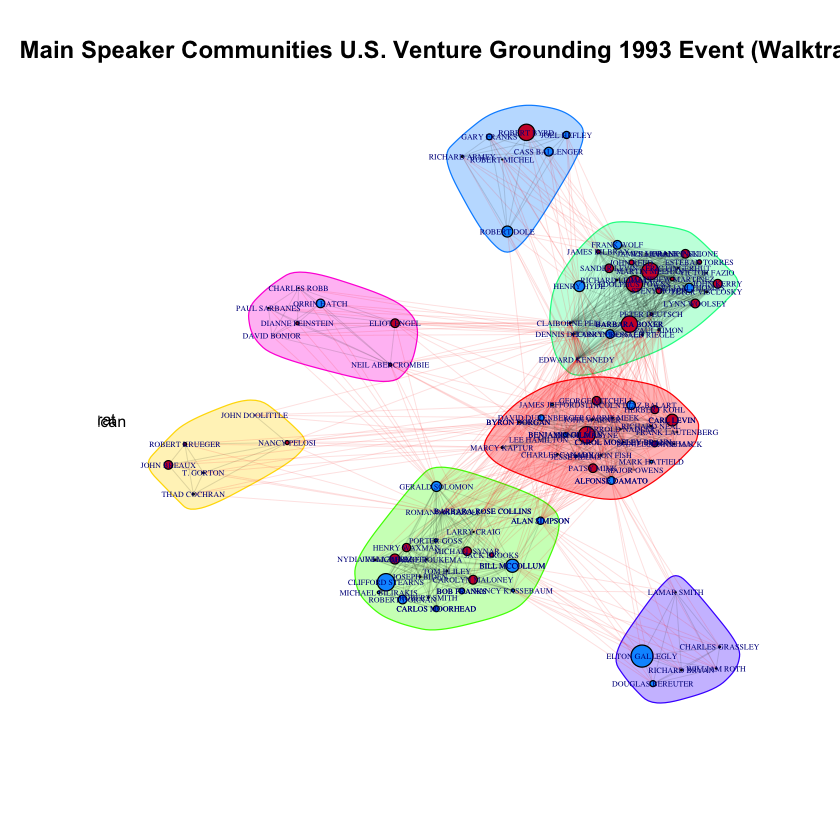

In [181]:
#old graphic code 
set.seed(1)
suppressWarnings(plot(c_sub_pre, gD2_pre, layout = l.group*1.6,
     col=colors[as.numeric(factor(nodes_party_sub_pre$party))],
     vertex.size = V(bn.m_pre)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label7))

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_sub_pre$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))

### POST

In [182]:
#subgraph
membership.data.post <- cbind(cluster_post$names, cluster_post$membership) %>%
  data.frame()

#filter out membership less than 5
big_group_post <- membership.data.post %>%
  group_by(X2) %>%
  filter(n() >= 5)
group_numbers_post <- membership.data.post %>%
  group_by(X2) %>%
  filter(n() >= 5) %>%
  pull(X2) %>%
 #as.numeric(.) %>%
  unique()


In [183]:
test4 <- membership.data.post %>%
    group_by(X2) %>%
    filter(n() >= 5) %>%
    pull(X2) %>%
    #as.numeric(.) 
    unique()

print(test4)

[1] "6" "7" "2" "8" "9" "3" "1" "4" "5"


In [184]:
big_names_post <- big_group_post$X1

nodes_party_sub_post <- nodes_party_post[sapply(lapply(nodes_party_post$display_as, `%in%`, big_names_post), any),]
nrow(nodes_party_sub_post)

[1] 152

In [185]:
#adjust to your bn.member_f_pre object
Keep_post = V(bn.m_post)[name %in% big_group_post$X1]

gD2_post  = induced_subgraph(bn.m_post, Keep_post)

In [186]:
c_sub_post = cluster_post
c_sub_post$names <- cluster_post$names[Keep_post]
c_sub_post$membership <- cluster_post$membership[cluster_post$membership %in% group_numbers_post]
c_sub_post$vcount <- length(c_sub_post$names)
c_sub_post$modularity <- modularity(gD2_post, c_sub_post$membership, E(gD2_post)$weight)

In [187]:
#determine largest group
table(cluster_post$membership) %>% sort()


13 10 11 12  8  7  4  6  1  5  3  9  2 
 1  2  2  2  5  6  7  9 12 13 15 25 60 

In [188]:
length(cluster_post$names)
length(cluster_post$membership)
length(cluster_post$modularity)

length(c_sub_post$names)
length(c_sub_post$membership)
length(c_sub_post$modularity)

[1] 159

[1] 159

[1] 159

[1] 152

[1] 152

[1] 1

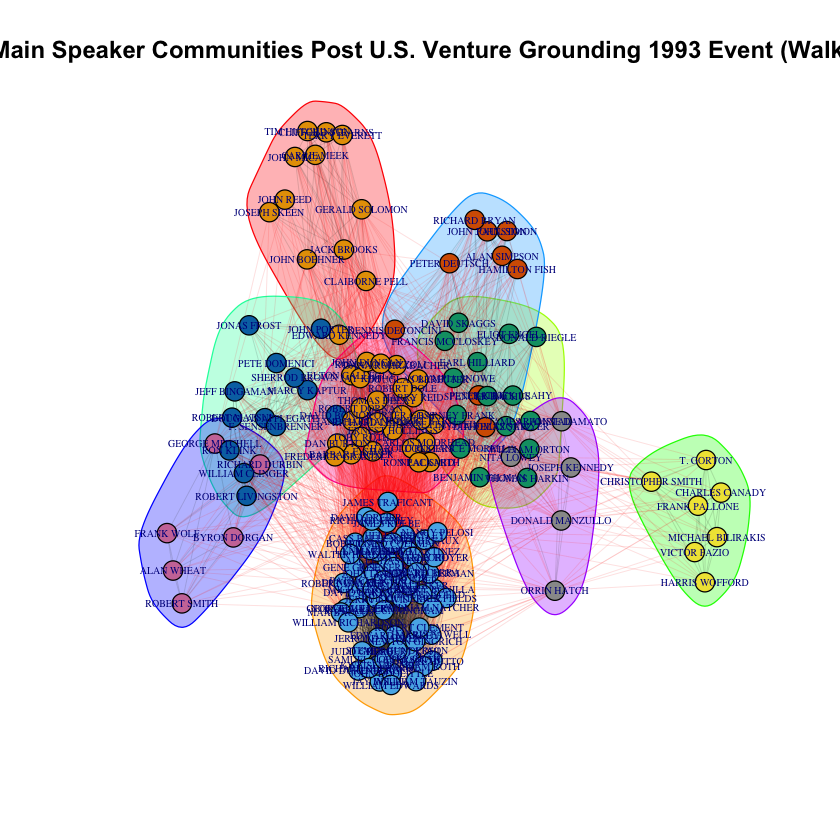

In [189]:
g_grouped_post2 = gD2_post

for(i in unique(V(gD2_post)$community2)){
  groupV = which(V(gD2_post)$community2 == i)
  g_grouped_post2 = add_edges(g_grouped_post2, combn(groupV, 2), attr=list(weight = 2))
}

l.group <- layout_with_fr(g_grouped_post2)
l.group <- suppressWarnings(norm_coords(l.group, ymin=-1, ymax=1, xmin=-0.9, xmax=1))

l14 <- layout_nicely(g_grouped_post2)

label14 = paste("Main Speaker Communities Post", event_name, "(Walktrap)", sep=" ")


set.seed(1)
plot(c_sub_post, gD2_post, layout = l.group*1.6, vertex.size = 7, edge.width = .1,
vertex.label.cex=.5, main = label14)
##plot

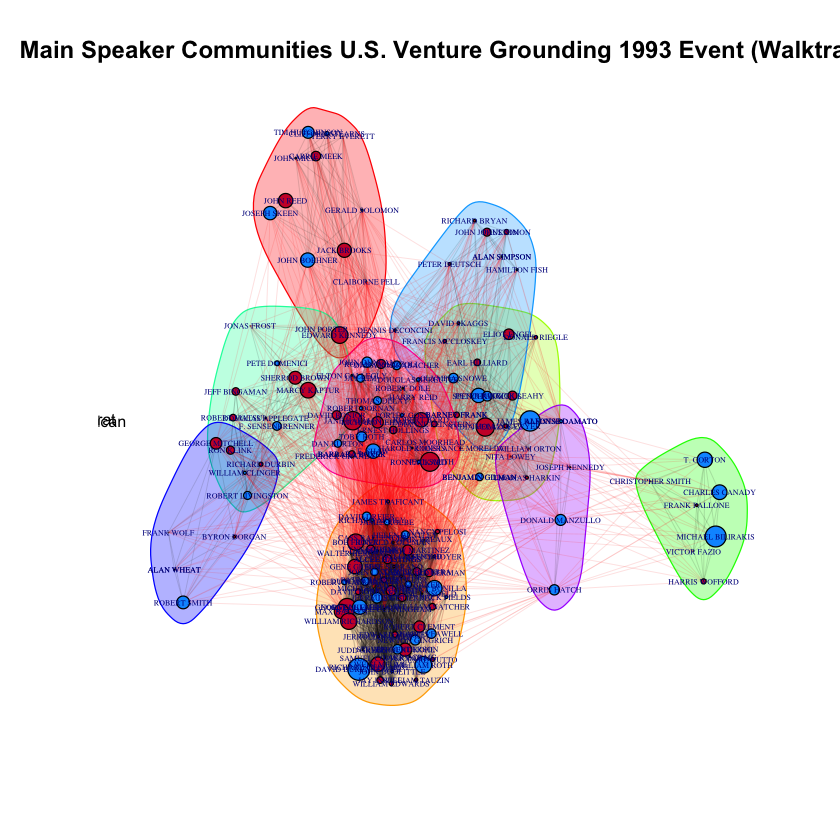

In [190]:
#old graphic code 
set.seed(1)
suppressWarnings(plot(c_sub_post, gD2_post, layout = l.group*1.6,
     col=colors[as.numeric(factor(nodes_party_sub_post$party))],
     vertex.size = V(bn.m_post)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label7))

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_sub_post$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))

# <font color='Brown'> Step 8: Centrality Measures</font>

### PRE

In [191]:
### Centrality measures 
### DEGREE centrality actors: 

head(sort(degree(bn.mem_f_pre), decreasing=F)) # fewest connections: 

head(sort(degree(bn.mem_f_pre), decreasing=T)) # most connections:

DANIEL COATS      IKE SKELTON      JOHN MCCAIN    JOHN WILLIAMS 
               4                4                4                4 
BARBARA MIKULSKI    JEFF BINGAMAN 
               5                5

EDWARD KENNEDY DENNIS DECONCINI   CLAIBORNE PELL   ROMANO MAZZOLI 
              71               57               49               46 
  LARRY PRESSLER    DONALD RIEGLE 
              45               43

In [192]:
### BETWEENNESS centrality actors: 
tail(sort(betweenness(bn.mem_f_pre,normalized = T))) # highest 

head(sort(betweenness(bn.mem_f_pre, normalized = T))) # lowest 

ALFONSE DAMATO        T. GORTON DENNIS DECONCINI   ROMANO MAZZOLI 
      0.06705587       0.06906949       0.09474541       0.09727211 
    ALAN SIMPSON   EDWARD KENNEDY 
      0.10134975       0.15599752

DANIEL COATS   IKE SKELTON   JOHN MCCAIN JOHN WILLIAMS  CHARLES ROBB 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  8.358409e-05 
 DAVID BONIOR 
 8.358409e-05

### POST

In [193]:
### Centrality measures 
### DEGREE centrality actors: 

head(sort(degree(bn.mem_f_post), decreasing=F)) # fewest connections: 

head(sort(degree(bn.mem_f_post), decreasing=T)) # most connections:

PHIL GRAMM    JESSE HELMS     JOHN OLVER    MAJOR OWENS RONALD DELLUMS 
             1              5              5              5              5 
    CARL LEVIN 
             6

DAVID DREIER JAMES TRAFICANT     JAMES KOLBE    NANCY PELOSI     LYNN SCHENK 
            116             112             107             107             101 
     GENE GREEN 
             92

In [194]:
### BETWEENNESS centrality actors: 
tail(sort(betweenness(bn.mem_f_post,normalized = T))) # highest 

head(sort(betweenness(bn.mem_f_post, normalized = T))) # lowest 

DANA ROHRABACHER  ERNEST HOLLINGS     DAVID BONIOR      PORTER GOSS 
      0.01978487       0.02321730       0.02553307       0.03003853 
 JAMES TRAFICANT     NANCY PELOSI 
      0.03279472       0.03727823

PHIL GRAMM     CARL LEVIN     JOHN KERRY    MAJOR OWENS RONALD DELLUMS 
  0.000000e+00   6.958762e-06   6.958762e-06   7.288759e-06   7.288759e-06 
   JESSE HELMS 
  8.187567e-06

# <font color='Grey'> Step 9: Extract Speaker and Community Info</font>

### PRE

In [195]:
### how to figure out who is in what community based on topics 
cluster_pre <- cluster_walktrap(bn.mem_f_pre, steps=2)
walk_comm <- as.data.frame(as.table(membership(cluster_pre)))
names(walk_comm) <- c("Speaker", "Community")

# create pre dataset again with speakers etc 

dfg_pre_2 <- subset(dfg, date>= before_90 & date <= before_1) %>%
    select(-date)


dfg_pre_2 = aggregate(dfg_pre_2,
                      by = list(dfg_pre_2$author),
                      FUN = max)

dfg_pre_2 <- dfg_pre_2 %>%
  select(-Group.1)

In [196]:
# Extract just names of speakers in each community 
fname = paste(event_name_pre, "STM_SpeakerbyCommunity.csv", sep="_")

pre_2steps_comm <- walk_comm
write.csv(pre_2steps_comm, file=fname)

In [197]:
# merge the dataset with communities now 
merge_dfg_pre <- merge(walk_comm, dfg_pre_2, walk_comm,  by.y = "author", by.x = "Speaker")

merge_dfg_pre[-1] <- lapply(merge_dfg_pre[-1], as.numeric)

# now create different metrics to see topic distribution per speaker/community
merge_dfg_pre <- merge_dfg_pre %>%
  mutate(topic_sum = rowSums(.[3:22])) %>%
  group_by(Community) %>%
  mutate(topic_mean = mean(topic_sum), topic_median = median(topic_sum), 
         topic_min = min(topic_sum),topic_max = max(topic_sum))

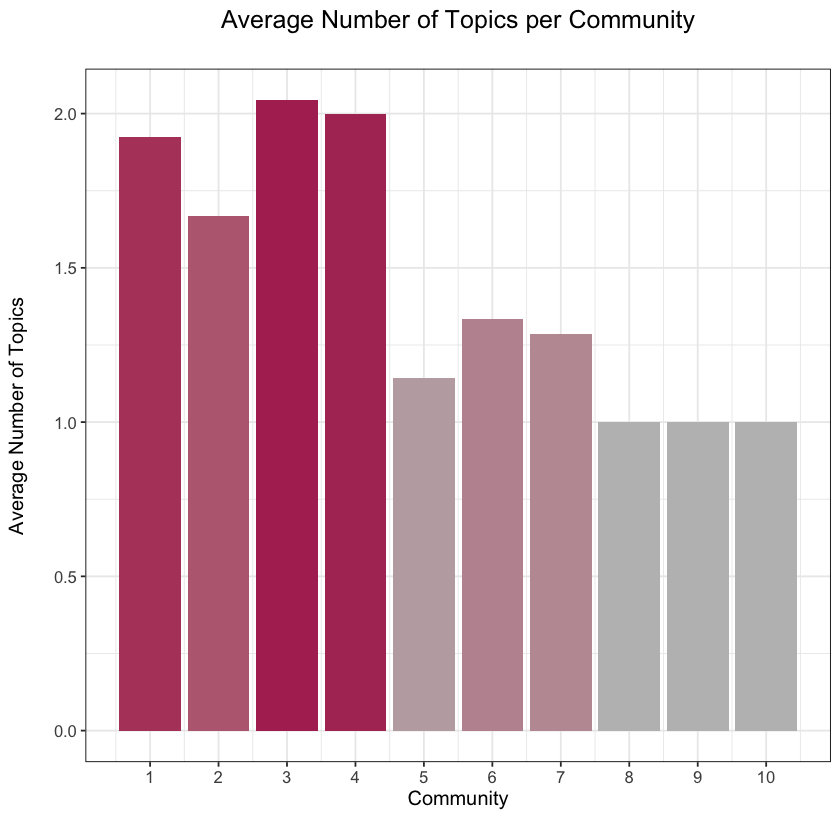

In [198]:
### Communities and Topics 

p1<- ggplot(merge_dfg_pre, aes(Community, topic_mean)) +
  geom_bar(aes(fill=topic_mean),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "maroon") +
  theme_bw() +
  ylab("Average Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Average Number of Topics per Community\n")

p1

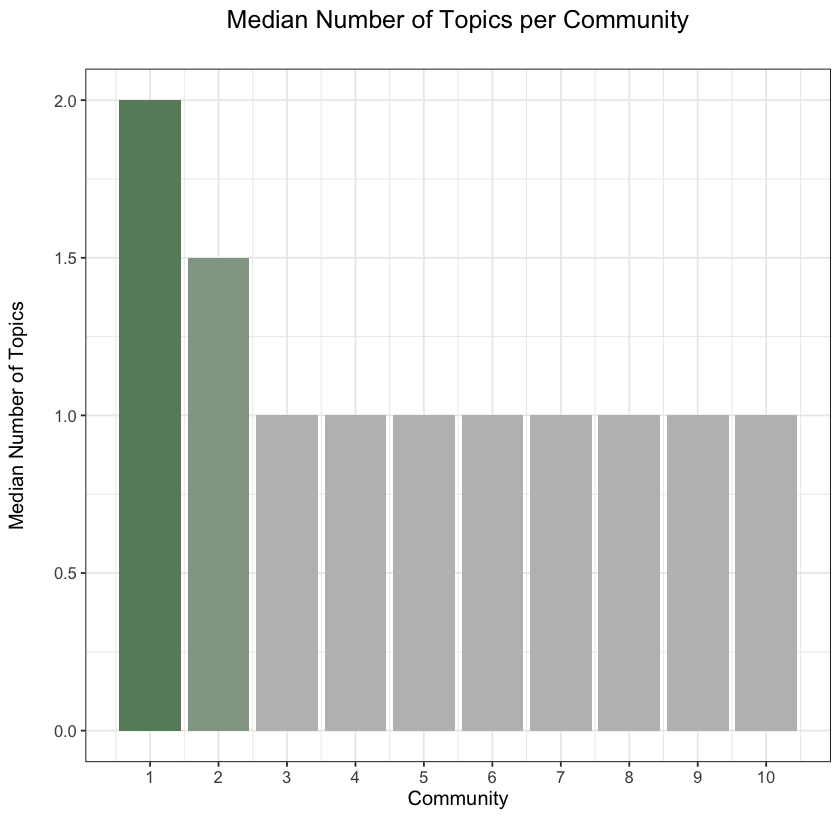

In [199]:
p2 <-  ggplot(merge_dfg_pre, aes(Community, topic_median)) +
  geom_bar(aes(fill=topic_median),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "darkseagreen4") +
  theme_bw() +
  ylab("Median Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Median Number of Topics per Community\n")

p2

In [200]:
#grid.arrange(p1, p2, nrow = 1) 
fname2 = paste(event_name_pre, "STM_NumSpeakersperCommunity.csv", sep="_")
# overall how often each topic is talked about 
colSums(merge_dfg_pre[ , c(3:22)], na.rm=TRUE)

# now how often each topic is talked about per community (ignore other columns, just focus on V1:V20)
aggregate(.~Community, merge_dfg_pre, sum)
walktrap_2steps <- aggregate(.~Community, merge_dfg_pre, sum)
write.csv(walktrap_2steps, file=fname2)

# count how many people in each community 
merge_dfg_pre %>% count(Community)

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
  8   6  13   8  27  10  10   4   2  19  13  10   4   8  11   5   9   8  11  13

Community Speaker V1 V2 V3 V4 V5 V6 V7 V8 ⋯ V16 V17 V18 V19 V20 topic_sum
1   1        1110    2  0   0 0   0 1  0  1  ⋯ 0   5   3   0   11  50       
2   2         514    5  0   0 0   0 0  0  2  ⋯ 1   0   0   0    0  10       
3   3        1299    1  1  12 4   0 3  1  0  ⋯ 0   1   0   0    1  47       
4   4        1769    0  0   1 0  27 0  2  1  ⋯ 0   2   4   4    1  56       
5   5         503    0  1   0 0   0 0  0  0  ⋯ 0   0   0   7    0   8       
6   6         356    0  1   0 0   0 6  0  0  ⋯ 0   0   0   0    0   8       
7   7         358    0  0   0 0   0 0  7  0  ⋯ 0   1   1   0    0   9       
8   8         283    0  0   0 4   0 0  0  0  ⋯ 0   0   0   0    0   4       
9   9         166    0  3   0 0   0 0  0  0  ⋯ 0   0   0   0    0   3       
10 10         197    0  0   0 0   0 0  0  0  ⋯ 4   0   0   0    0   4       
   topic_mean topic_median topic_min topic_max
1  50         52           26        104      
2  10          9            6         18      
3  47         23           23        138      
4  56         28           28        196      
5   8          7            7         14      
6   8          6            6         12      
7   9          7            7         14      
8   4          4            4          4      
9   3          3            3          3      
10  4          4            4          4

Community n 
1   1        26
2   2         6
3   3        23
4   4        28
5   5         7
6   6         6
7   7         7
8   8         4
9   9         3
10 10         4

### POST

In [201]:
### how to figure out who is in what community based on topics 
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2)
walk_comm_post <- as.data.frame(as.table(membership(cluster_post)))
names(walk_comm_post) <- c("Speaker", "Community")

# create pre dataset again with speakers etc 

dfg_post_2 <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)

dfg_post_2 = aggregate(dfg_post_2,
                      by = list(dfg_post_2$author),
                      FUN = max)

dfg_post_2 <- dfg_post_2 %>%
  select(-Group.1)

In [202]:
# Extract just names of speakers in each community 
fname = paste(event_name_post, "STM_SpeakerbyCommunity.csv", sep="_")

post_2steps_comm <- walk_comm_post
write.csv(post_2steps_comm, file=fname)

In [203]:
# merge the dataset with communities now 
merge_dfg_post <- merge(walk_comm_post, dfg_post_2, walk_comm_post,  by.y = "author", by.x = "Speaker")

merge_dfg_post[-1] <- lapply(merge_dfg_post[-1], as.numeric)

# now create different metrics to see topic distribution per speaker/community
merge_dfg_post <- merge_dfg_post %>%
  mutate(topic_sum = rowSums(.[3:22])) %>%
  group_by(Community) %>%
  mutate(topic_mean = mean(topic_sum), topic_median = median(topic_sum), 
         topic_min = min(topic_sum),topic_max = max(topic_sum))

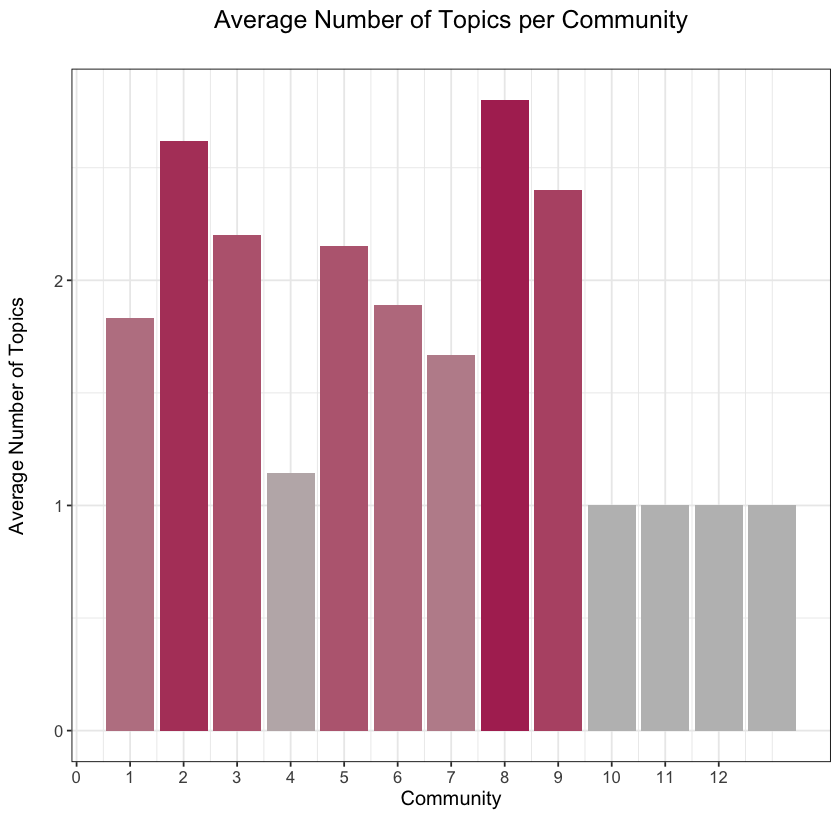

In [204]:
### Communities and Topics 

p3<- ggplot(merge_dfg_post, aes(Community, topic_mean)) +
  geom_bar(aes(fill=topic_mean),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "maroon") +
  theme_bw() +
  ylab("Average Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Average Number of Topics per Community\n")

p3

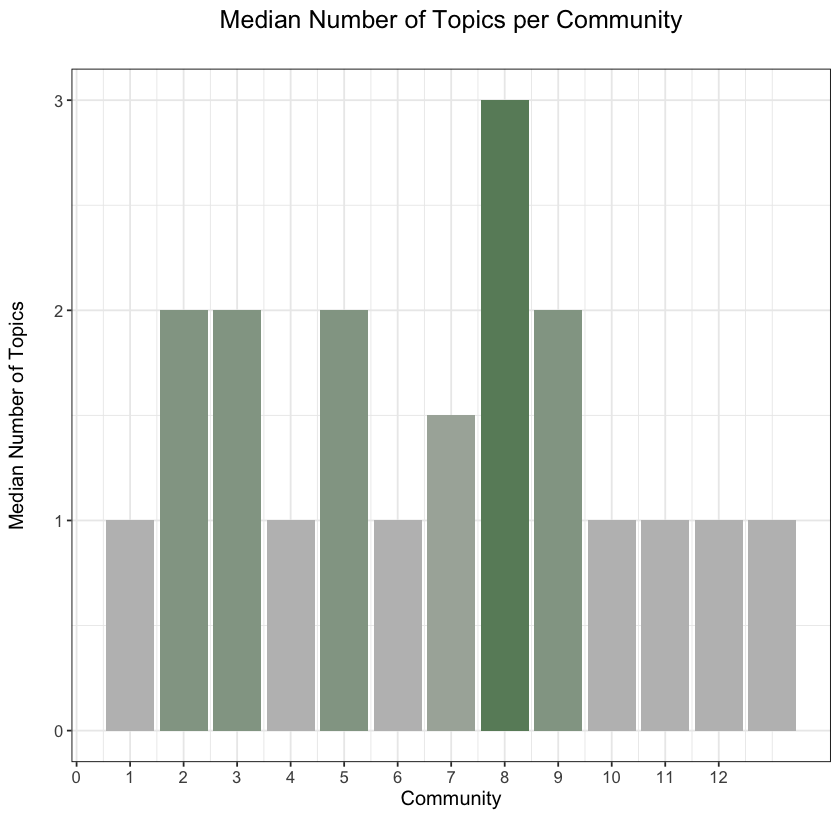

In [205]:
p4 <-  ggplot(merge_dfg_post, aes(Community, topic_median)) +
  geom_bar(aes(fill=topic_median),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "darkseagreen4") +
  theme_bw() +
  ylab("Median Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Median Number of Topics per Community\n")

p4

In [206]:
#grid.arrange(p1, p2, nrow = 1) 
fname2 = paste(event_name_post, "STM_NumSpeakersperCommunity.csv", sep="_")
# overall how often each topic is talked about 
colSums(merge_dfg_post[ , c(3:22)], na.rm=TRUE)

# now how often each topic is talked about per community (ignore other columns, just focus on V1:V20)
aggregate(.~Community, merge_dfg_post, sum)
walktrap_2steps_post <- aggregate(.~Community, merge_dfg_post, sum)
write.csv(walktrap_2steps_post, file=fname2)

# count how many people in each community 
merge_dfg_post %>% count(Community)

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
 21  21   9  53   2  20   6  14  47  12  17  29  20  16  15   7  13  14  14   6

Community Speaker V1 V2 V3 V4 V5 V6 V7 V8 ⋯ V16 V17 V18 V19 V20 topic_sum
1   1         806     0  0 0   0 0  0  0  2  ⋯ 0   0   0   1   0    22      
2   2        5271     8 17 3  53 0  3  0  3  ⋯ 0   1   5   5   1   157      
3   3        1064     0  0 2   0 0  0  1  1  ⋯ 2   0   0   2   0    33      
4   4         516     0  0 0   0 0  0  1  0  ⋯ 0   7   0   0   0     8      
5   5        1212    10  0 0   0 0  0  1  5  ⋯ 1   0   3   2   1    28      
6   6         719     1  2 1   0 1  9  0  1  ⋯ 0   0   0   0   0    17      
7   7         355     0  0 0   0 0  0  0  0  ⋯ 0   0   6   2   0    10      
8   8         331     0  1 1   0 0  1  0  0  ⋯ 0   5   0   0   1    14      
9   9        1860     2  1 2   0 0  7  1  2  ⋯ 2   0   0   2   1    60      
10 10          88     0  0 0   0 0  0  0  0  ⋯ 2   0   0   0   0     2      
11 11         230     0  0 0   0 0  0  0  0  ⋯ 0   0   0   0   2     2      
12 12         153     0  0 0   0 0  0  2  0  ⋯ 0   0   0   0   0     2      
13 13         115     0  0 0   0 1  0  0  0  ⋯ 0   0   0   0   0     1      
   topic_mean topic_median topic_min topic_max
1   22         12          12         48      
2  157        120          60        480      
3   33         30          15         60      
4    8          7           7         14      
5   28         26          13         78      
6   17          9           9         36      
7   10          9           6         18      
8   14         15          10         20      
9   60         50          25        125      
10   2          2           2          2      
11   2          2           2          2      
12   2          2           2          2      
13   1          1           1          1

Community n 
1   1        12
2   2        60
3   3        15
4   4         7
5   5        13
6   6         9
7   7         6
8   8         5
9   9        25
10 10         2
11 11         2
12 12         2
13 13         1

# <font color='Red'> STEP 10:  Full Network Measures of Centrality, Transitivity, etc.</font>

In [207]:
pre_cent = centr_degree(bn.mem_f_pre)$centralization  ### somewhat high: 0.56 --> this speaks confirms that the network
pre_centrality = paste("Centrality of Pre", event_name, ":", pre_cent, sep=" ")
print(pre_centrality)
# is rather decentralized and hierarchical, with only a few nodes/actors being most important 
post_cent = centr_degree(bn.mem_f_post)$centralization
post_centrality = paste("Centrality of Post", event_name, ":", post_cent, sep=" ")
print(post_centrality)

cent_change = post_cent - pre_cent
centrality_change = paste("Change in Centrality", event_name, ":", cent_change, sep=" ")
print(centrality_change)

[1] "Centrality of Pre U.S. Venture Grounding 1993 Event : 0.459866480360193"
[1] "Centrality of Post U.S. Venture Grounding 1993 Event : 0.430220523843643"
[1] "Change in Centrality U.S. Venture Grounding 1993 Event : -0.0296459565165495"


In [208]:
pre_edge = edge_density(bn.mem_f_pre) 
pre_edge_density = paste("Edge Density of Pre", event_name, ":", pre_edge, sep=" ")
print(pre_edge_density)

post_edge = edge_density(bn.mem_f_post)
post_edge_density = paste("Edge Density of Post", event_name, ":", post_edge, sep=" ")
print(post_edge_density)

edge_change = post_edge - pre_edge
density_change = paste("Change in Density", event_name, ":", edge_change, sep=" ")
print(density_change)

[1] "Edge Density of Pre U.S. Venture Grounding 1993 Event : 0.168452103710604"
[1] "Edge Density of Post U.S. Venture Grounding 1993 Event : 0.30395669134623"
[1] "Change in Density U.S. Venture Grounding 1993 Event : 0.135504587635626"


In [209]:
pre_trans = transitivity(bn.mem_f_pre) 
pre_transitivity = paste("Transitivity of Pre", event_name, ":", pre_trans, sep=" ")
print(pre_transitivity)

post_trans = transitivity(bn.mem_f_post)
post_transitivity = paste("Transitivity of Post", event_name, ":", post_trans, sep=" ")
print(post_transitivity)

trans_change = post_trans - pre_trans
transitivity_change = paste("Change in Transitivity", event_name, ":", trans_change, sep=" ")
print(transitivity_change)

[1] "Transitivity of Pre U.S. Venture Grounding 1993 Event : 0.632996274614156"
[1] "Transitivity of Post U.S. Venture Grounding 1993 Event : 0.674065371543658"
[1] "Change in Transitivity U.S. Venture Grounding 1993 Event : 0.0410690969295016"


In [210]:
# Pre-event average path length
pre_path = mean_distance(bn.mem_f_pre)
pre_path_length = paste("Average Path Length of Pre", event_name, ":", pre_path, sep=" ")
print(pre_path_length)

# Post-event average path length
post_path = mean_distance(bn.mem_f_post)
post_path_length = paste("Average Path Length of Post", event_name, ":", post_path, sep=" ")
print(post_path_length)

# Change in average path length
path_change = post_path - pre_path
path_length_change = paste("Change in Average Path Length", event_name, ":", path_change, sep=" ")
print(path_length_change)

[1] "Average Path Length of Pre U.S. Venture Grounding 1993 Event : 2.15261605340786"
[1] "Average Path Length of Post U.S. Venture Grounding 1993 Event : 1.80670328795478"
[1] "Change in Average Path Length U.S. Venture Grounding 1993 Event : -0.345912765453075"


In [211]:
#Get table with raw and changes:
# Calculate all network measures (your existing code creates these values)
# Pre values
pre_cent <- centr_degree(bn.mem_f_pre)$centralization
pre_edge <- edge_density(bn.mem_f_pre)
pre_trans <- transitivity(bn.mem_f_pre)
pre_path <- mean_distance(bn.mem_f_pre)

# Post values
post_cent <- centr_degree(bn.mem_f_post)$centralization
post_edge <- edge_density(bn.mem_f_post)
post_trans <- transitivity(bn.mem_f_post)
post_path <- mean_distance(bn.mem_f_post)

# Create summary table
network_summary <- data.frame(
  Measure = c("Degree Centralization", "Edge Density", "Transitivity", "Average Path Length"),
  Pre_Event = c(pre_cent, pre_edge, pre_trans, pre_path),
  Post_Event = c(post_cent, post_edge, post_trans, post_path),
  Raw_Change = c(post_cent - pre_cent, 
                 post_edge - pre_edge, 
                 post_trans - pre_trans, 
                 post_path - pre_path),
  Percent_Change = c(((post_cent - pre_cent) / pre_cent) * 100,
                     ((post_edge - pre_edge) / pre_edge) * 100,
                     ((post_trans - pre_trans) / pre_trans) * 100,
                     ((post_path - pre_path) / pre_path) * 100)
)

# Round for readability
network_summary$Pre_Event <- round(network_summary$Pre_Event, 4)
network_summary$Post_Event <- round(network_summary$Post_Event, 4)
network_summary$Raw_Change <- round(network_summary$Raw_Change, 4)
network_summary$Percent_Change <- round(network_summary$Percent_Change, 2)

# Print the table
print(network_summary)

# Optional: Create a nicer formatted table
library(knitr)
kable(network_summary, 
      caption = paste("Network Measure Changes for", event_name),
      col.names = c("Measure", "Pre-Event", "Post-Event", "Raw Change", "% Change"))

# Optional: Save to CSV
write.csv(network_summary, 
          file = paste0("network_changes_", event_name, "full",".csv"), 
          row.names = FALSE)

                Measure Pre_Event Post_Event Raw_Change Percent_Change
1 Degree Centralization    0.4599     0.4302    -0.0296          -6.45
2          Edge Density    0.1685     0.3040     0.1355          80.44
3          Transitivity    0.6330     0.6741     0.0411           6.49
4   Average Path Length    2.1526     1.8067    -0.3459         -16.07




Table: Network Measure Changes for U.S. Venture Grounding 1993 Event

|Measure               | Pre-Event| Post-Event| Raw Change| % Change|
|:---------------------|---------:|----------:|----------:|--------:|
|Degree Centralization |    0.4599|     0.4302|    -0.0296|    -6.45|
|Edge Density          |    0.1685|     0.3040|     0.1355|    80.44|
|Transitivity          |    0.6330|     0.6741|     0.0411|     6.49|
|Average Path Length   |    2.1526|     1.8067|    -0.3459|   -16.07|

## <font color='Red'> SUBGraph Measures of Centrality, Transitivity, etc.</font>

In [212]:
pre_cent = centr_degree(gD2_pre)$centralization  ### somewhat high: 0.56 --> this speaks confirms that the network
pre_centrality = paste("Centrality of Pre", event_name, ":", pre_cent, sep=" ")
print(pre_centrality)
# is rather decentralized and hierarchical, with only a few nodes/actors being most important 
post_cent = centr_degree(gD2_post)$centralization
post_centrality = paste("Centrality of Post", event_name, ":", post_cent, sep=" ")
print(post_centrality)

cent_change = post_cent - pre_cent
centrality_change = paste("Change in Centrality", event_name, ":", cent_change, sep=" ")
print(centrality_change)

[1] "Centrality of Pre U.S. Venture Grounding 1993 Event : 0.497905958499905"
[1] "Centrality of Post U.S. Venture Grounding 1993 Event : 0.43813175322412"
[1] "Change in Centrality U.S. Venture Grounding 1993 Event : -0.0597742052757849"


In [213]:
pre_edge = edge_density(gD2_pre) 
pre_edge_density = paste("Edge Density of Pre", event_name, ":", pre_edge, sep=" ")
print(pre_edge_density)

post_edge = edge_density(gD2_post)
post_edge_density = paste("Edge Density of Post", event_name, ":", post_edge, sep=" ")
print(post_edge_density)

edge_change = post_edge - pre_edge
density_change = paste("Change in Density", event_name, ":", edge_change, sep=" ")
print(density_change)

[1] "Edge Density of Pre U.S. Venture Grounding 1993 Event : 0.198172472872644"
[1] "Edge Density of Post U.S. Venture Grounding 1993 Event : 0.330080167305681"
[1] "Change in Density U.S. Venture Grounding 1993 Event : 0.131907694433037"


In [214]:
pre_trans = transitivity(gD2_pre) 
pre_transitivity = paste("Transitivity of Pre", event_name, ":", pre_trans, sep=" ")
print(pre_transitivity)

post_trans = transitivity(gD2_post)
post_transitivity = paste("Transitivity of Post", event_name, ":", post_trans, sep=" ")
print(post_transitivity)

trans_change = post_trans - pre_trans
transitivity_change = paste("Change in Transitivity", event_name, ":", trans_change, sep=" ")
print(transitivity_change)

[1] "Transitivity of Pre U.S. Venture Grounding 1993 Event : 0.644497344808643"
[1] "Transitivity of Post U.S. Venture Grounding 1993 Event : 0.677086585602538"
[1] "Change in Transitivity U.S. Venture Grounding 1993 Event : 0.0325892407938951"


In [215]:
# Pre-event average path length
pre_path = mean_distance(gD2_pre)
pre_path_length = paste("Average Path Length of Pre", event_name, ":", pre_path, sep=" ")
print(pre_path_length)

# Post-event average path length
post_path = mean_distance(gD2_post)
post_path_length = paste("Average Path Length of Post", event_name, ":", post_path, sep=" ")
print(post_path_length)

# Change in average path length
path_change = post_path - pre_path
path_length_change = paste("Change in Average Path Length", event_name, ":", path_change, sep=" ")
print(path_length_change)

[1] "Average Path Length of Pre U.S. Venture Grounding 1993 Event : 2.01085094231868"
[1] "Average Path Length of Post U.S. Venture Grounding 1993 Event : 1.75775531544092"
[1] "Change in Average Path Length U.S. Venture Grounding 1993 Event : -0.253095626877755"


In [216]:
# Calculate all network measures
# Pre values
pre_cent <- centr_degree(gD2_pre)$centralization
pre_edge <- edge_density(gD2_pre)
pre_trans <- transitivity(gD2_pre)
pre_path <- mean_distance(gD2_pre)

# Post values
post_cent <- centr_degree(gD2_post)$centralization
post_edge <- edge_density(gD2_post)
post_trans <- transitivity(gD2_post)
post_path <- mean_distance(gD2_post)

# Create summary table
network_summary <- data.frame(
  Measure = c("Degree Centralization", "Edge Density", "Transitivity", "Average Path Length"),
  Pre_Event = c(pre_cent, pre_edge, pre_trans, pre_path),
  Post_Event = c(post_cent, post_edge, post_trans, post_path),
  Raw_Change = c(post_cent - pre_cent, 
                 post_edge - pre_edge, 
                 post_trans - pre_trans, 
                 post_path - pre_path),
  Percent_Change = c(((post_cent - pre_cent) / pre_cent) * 100,
                     ((post_edge - pre_edge) / pre_edge) * 100,
                     ((post_trans - pre_trans) / pre_trans) * 100,
                     ((post_path - pre_path) / pre_path) * 100)
)

# Round for readability
network_summary$Pre_Event <- round(network_summary$Pre_Event, 4)
network_summary$Post_Event <- round(network_summary$Post_Event, 4)
network_summary$Raw_Change <- round(network_summary$Raw_Change, 4)
network_summary$Percent_Change <- round(network_summary$Percent_Change, 2)

# Print the table
print(network_summary)

# Optional: Create a nicer formatted table
library(knitr)
kable(network_summary, 
      caption = paste("Network Measure Changes for", event_name),
      col.names = c("Measure", "Pre-Event", "Post-Event", "Raw Change", "% Change"))

# Optional: Save to CSV
write.csv(network_summary, 
          file = paste0("network_changes_", event_name, "core", ".csv"), 
          row.names = FALSE)

                Measure Pre_Event Post_Event Raw_Change Percent_Change
1 Degree Centralization    0.4979     0.4381    -0.0598         -12.01
2          Edge Density    0.1982     0.3301     0.1319          66.56
3          Transitivity    0.6445     0.6771     0.0326           5.06
4   Average Path Length    2.0109     1.7578    -0.2531         -12.59




Table: Network Measure Changes for U.S. Venture Grounding 1993 Event

|Measure               | Pre-Event| Post-Event| Raw Change| % Change|
|:---------------------|---------:|----------:|----------:|--------:|
|Degree Centralization |    0.4979|     0.4381|    -0.0598|   -12.01|
|Edge Density          |    0.1982|     0.3301|     0.1319|    66.56|
|Transitivity          |    0.6445|     0.6771|     0.0326|     5.06|
|Average Path Length   |    2.0109|     1.7578|    -0.2531|   -12.59|

In [219]:
table(post_2steps_comm$community)

< table of extent 0 >

In [225]:
df <- data.frame(values = post_2steps_comm)

In [227]:
table(df$values.Community)


 1  2  3  4  5  6  7  8  9 10 11 12 13 
12 60 15  7 13  9  6  5 25  2  2  2  1 

In [228]:
df_pre <- data.frame(values = pre_2steps_comm)
table(df_pre$values.Community)


 1  2  3  4  5  6  7  8  9 10 
26  6 23 28  7  6  7  4  3  4 

In [229]:
write.csv(df_event, "US_Venture1993_allSpeeches.csv")